In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import cv2
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [4]:
train1_dataset_path = 'data/train_Images_Source_1/'
train2_dataset_path = 'data/train_Images_Source_2/'
validation_dataset_path = 'data/test_data/'

In [27]:
train = 'data/train_folder'
val = 'data/val_folder'

In [5]:
IMG_WIDTH = 150
IMG_HEIGHT = 150
BATCH_SIZE = 32

In [28]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                  zoom_range=0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(train,
                                                   target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                   batch_size=BATCH_SIZE,
                                                   class_mode='categorical',
                                                   shuffle=True)

Found 9528 images belonging to 15 classes.


In [29]:
validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(val,
                                                             target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                             batch_size=BATCH_SIZE,
                                                             class_mode='categorical',
                                                             shuffle=True)

Found 2382 images belonging to 15 classes.


In [30]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : Ascariasis
1 : Babesia
2 : Capillaria p
3 : Enterobius v
4 : Epidermophyton floccosum
5 : Fasciolopsis buski
6 : Hookworm egg
7 : Hymenolepis diminuta
8 : Hymenolepis nana
9 : Leishmania
10 : Opisthorchis viverrine
11 : Paragonimus spp
12 : T. rubrum
13 : Taenia spp
14 : Trichuris trichiura


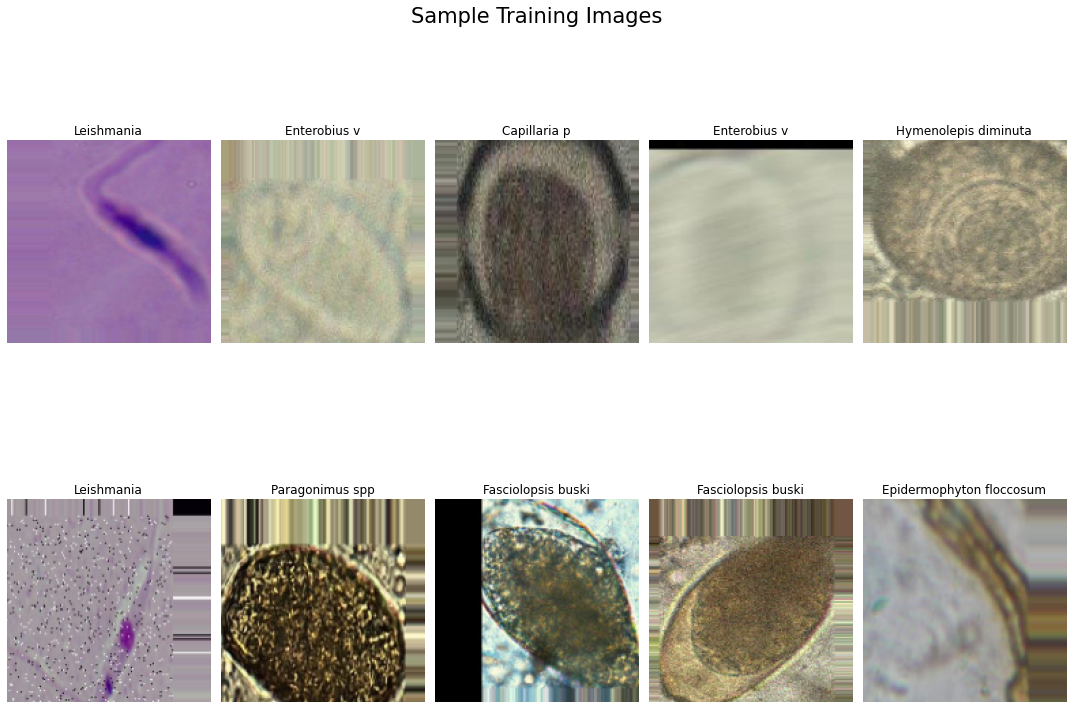

In [31]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))
idx = 0

for i in range(2):
    for j in range(5):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()

In [38]:
def create_model():
    model = Sequential([
        Conv2D(filters=128, kernel_size=(5, 5), padding='valid', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(filters=64, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(filters=32, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Flatten(),
        
        Dense(units=256, activation='relu'),
        Dropout(0.5),
        Dense(units=15, activation='softmax')
    ])
    
    return model

In [39]:
cnn_model = create_model()
print(cnn_model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 146, 146, 128)     9728      
                                                                 
 activation_6 (Activation)   (None, 146, 146, 128)     0         
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 73, 73, 128)       0         
 g2D)                                                            
                                                                 
 batch_normalization_6 (Bat  (None, 73, 73, 128)       512       
 chNormalization)                                                
                                                                 
 conv2d_7 (Conv2D)           (None, 71, 71, 64)        73792     
                                                                 
 activation_7 (Activation)   (None, 71, 71, 64)       

In [40]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)

In [41]:
optimizer = Adam(learning_rate=0.001)

In [42]:
cnn_model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])

In [43]:
history = cnn_model.fit(train_generator, epochs=50, validation_data=validation_generator,
                       verbose=2,
                       callbacks=[reduce_lr])

Epoch 1/50


KeyboardInterrupt: 

In [17]:
import os
import random
import shutil
from sklearn.model_selection import train_test_split


In [18]:
dataset = []
for category in os.listdir(train1_dataset_path):
    category_path = os.path.join(train1_dataset_path, category)
    if os.path.isdir(category_path):
        for image_file in os.listdir(category_path):
            image_path = os.path.join(category_path, image_file)
            dataset.append((image_path, category))

In [20]:
for image_file in os.listdir(train2_dataset_path):
    category = image_file.split('_')[0]  # Extract category from the image file name
    image_path = os.path.join(train2_dataset_path, image_file)
    dataset.append((image_path, category))


In [21]:
random.shuffle(dataset)


In [25]:
train_ratio = 0.8  # Adjust as needed
train_size = int(len(dataset) * train_ratio)

train_dataset = dataset[:train_size]
val_dataset = dataset[train_size:]

In [26]:
train_folder = 'data/train_folder'
val_folder = 'data/val_folder'

for image_path, category in train_dataset:
    category_folder = os.path.join(train_folder, category)
    os.makedirs(category_folder, exist_ok=True)
    shutil.copy(image_path, category_folder)

for image_path, category in val_dataset:
    category_folder = os.path.join(val_folder, category)
    os.makedirs(category_folder, exist_ok=True)
    shutil.copy(image_path, category_folder)